# Demonstrate functions dealing with em follow-up

## new events from gracedb

In [12]:
# TODO: remove this once done developing

import importlib

# Import the module
import bot.new_events_utils

# Re-import the specific function
GetSuperevents = importlib.reload(bot.new_events_utils).GetSuperevents

Credentials file loaded successfully.


In [5]:
# get events from gracedb that we haven't already saved

from bot.new_events_utils import GetSuperevents
params = GetSuperevents(path_events_dictionary='bot/data', 
                        mlp_modelpath='bot/mlp_model.sav',
                        event_source='gracedb',
                        runid='O4c',
                        retrieve_all=False).get_new_events()

19 significant superevents in O4c
0 new events to process (cut 3 low prob bbh events)


In [6]:
# check the trigger status on fritz and check if we handled the event correctly

eventid = [x[0] for x in params]
dateid = [x[12] for x in params]
a90 = [x[16] for x in params]
far = [x[9] for x in params]
mass = [x[22] for x in params]

from bot.new_events_utils import Fritz
trigger_status = Fritz(eventid, dateid, a90, far, mass).get_trigger_status()

There are currently 129 observation plans generated
0 errors, 0 correct, 0 inspect


In [7]:
# compile event information and save to the dictionary of events

from bot.new_events_utils import NewEventsToDict
df = NewEventsToDict(params, trigger_status, path_events_dictionary='bot/data', check_before_run=False).save_data()
df

New events saved to dictionary.


,GW MJD,90% Area (deg2),50% Area (deg2),Distance (Gpc),FAR (years/FA),Mass (M_sol),gcnids,trigger,plan time,plan probability,plan start,cadence
graceids,,,,,,,,,,,,


In [7]:
# default arguments set at contour=90, mindec=-90

eventid = [x[0] for x in params]
skymap_str = [x[18] for x in params]
zmin = [x[19] for x in params]
zmax = [x[20] for x in params]

from bot.new_events_utils import KowalskiCrossmatch
crossmatch = KowalskiCrossmatch(eventid, skymap_str, dateid, zmin, zmax, path_events_dictionary='bot/data')
matches = crossmatch.get_crossmatches()

0 events are missing crossmatch: []
data for these events were provided, but they were skipped because only new crossmatches were performed: {'S250319bu'}
Crossmatching 0 events: []
No catnorth crossmatch


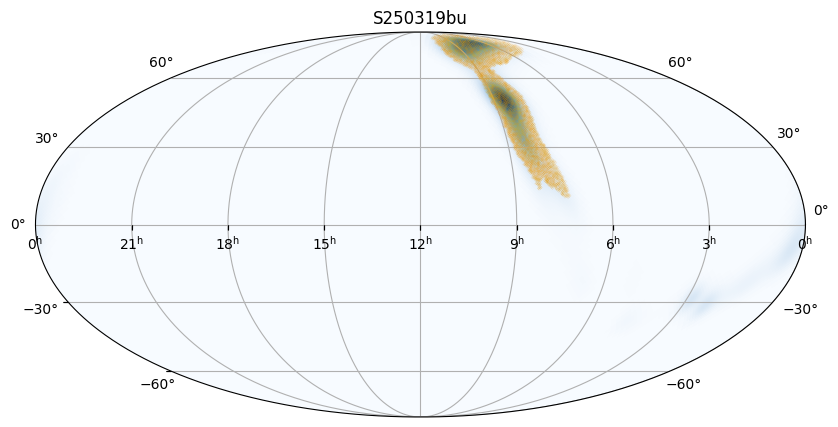

In [4]:
from bot.new_events_utils import PlotSkymap
PlotSkymap(gracedbid='S250319bu', path_events_dictionary='bot/data', runid='O4c').plot(show_agn=True)

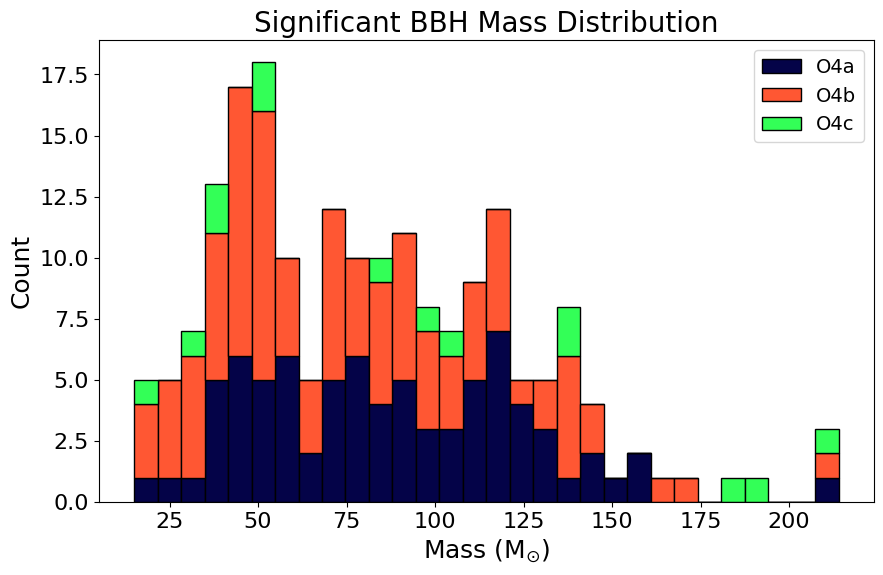

In [5]:
from bot.new_events_utils import VisualizePop
VisualizePop(path_events_dictionary='bot/data', runid=['O4a', 'O4b','O4c']).plot_masses()

In [13]:
from bot.new_events_utils import PushEventsPublic
summary_events = PushEventsPublic(path_events_dictionary='bot/data',
                                                            path_events_summary='../events_summary',
                                                            testing=True, 
                                                            verbose=True)

df, priority, trigger_df, error_triggers = summary_events.format_and_push()

2 O4c events with FAR > 10 and mass > 60 and area < 1000 sq deg


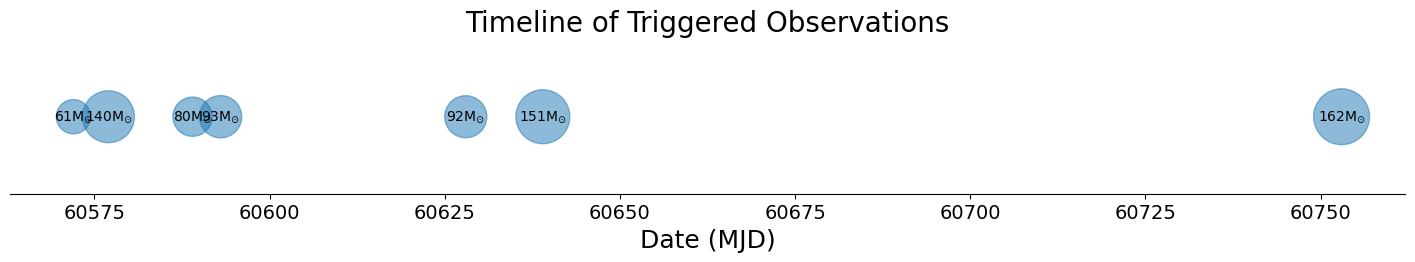

In [14]:
summary_events.plot_trigger_timeline()

# ZTF forced photometry service

In [15]:
# TODO: remove this once done developing    

import importlib
# Import the module
import bot.photometry_utils
importlib.reload(bot.photometry_utils)

Credentials file loaded successfully.
Credentials file loaded successfully.


<module 'bot.photometry_utils' from '/home/kira/mypy/repos/BBHBot/FlareBot/bot/photometry_utils.py'>

In [16]:
# check photometry status

from bot.photometry_utils import PhotometryStatus
PhotometryStatus(observing_run='O4c', path_events_dictionary='bot/data').show_status()

12 / 14 events in O4c are not priority


,ID,Date last zfps,Status,Trigger
0,S250319bu,2025-04-11 23:01:30.994,update ZFPS,True
1,S250204ax,,needs ZFPS,


424 / 23880 dataframes for 24284 Catnorth sources are empty


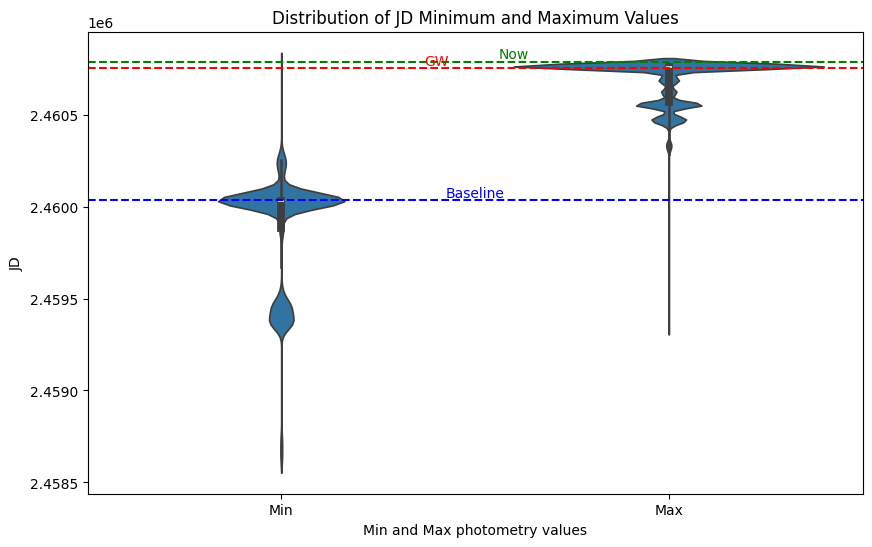

In [17]:
# check our photometry coverage

from bot.photometry_utils import PlotPhotometry
PlotPhotometry(observing_run='O4c', graceid='S250319bu', path_events_dictionary='bot/data', path_photometry='../../../data/bbh/ZFPS/').plot_photometry_dates()

In [59]:
from bot.photometry_utils import PhotometryCoords
ra, dec, jd = PhotometryCoords(action='new', 
                               graceid='S250319bu', 
                               catalog=['catnorth'], 
                               verbose=True,
                               path_events_dictionary='bot/data',
                               path_photometry='../../../data/bbh/ZFPS/',
                               observing_run='O4c').get_photometry_coords()

18140 / 24284 total coords dont have photometry
More than 1500 AGN - submit in 13 batches
Retrieved 15000 AGN for submission now


In [71]:
from bot.photometry_utils import GetPhotometry

submit = GetPhotometry(ra, 
              dec, 
              jd, 
              graceid='S250319bu', 
              observing_run='O4c', 
              path_events_dictionary='bot/data').submit()

submit in 10 batches
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Submitted 15000 AGN in 10 batches at 2025-04-02 19:05:25.521


In [ ]:
from bot.photometry_utils import SavePhotometry

#SavePhotometry(graceid='S250319bu', batch_codes=['11127'], action='update', path_photometry='../../../data/bbh/ZFPS/').save_photometry()

## rolling window heuristic for flares

In [55]:
import importlib
import bot.flares_utils
importlib.reload(bot.flares_utils)

<module 'bot.flares_utils' from '/home/kira/mypy/repos/BBHBot/FlareBot/bot/flares_utils.py'>

In [56]:
from bot.flares_utils import FlarePreprocessing
AGN = FlarePreprocessing(graceid='S241114y', 
                         path_events_dictionary='bot/data', 
                         path_photometry='../../../data/bbh/ZFPS/').process_for_flare()

found 3819 AGN


In [57]:
# default arguments window_size_before=50, window_size_after=25, baseline_years=2

from bot.flares_utils import RollingWindowStats
stats = RollingWindowStats(graceid='S241114y', agn=AGN, path_events_dictionary='bot/data').get_rolling_window_stats()

In [58]:
# k_mad defines the scalar on the mean absolute deviations that a point in the GW window must be brighter than,
# percent defines the percentage of baseline medians that must meet this criteria

from bot.flares_utils import RollingWindowHeuristic
g, r, i, gr, gri = RollingWindowHeuristic(graceid='S241114y', 
                                          agn=AGN, 
                                          rolling_stats=stats, 
                                          path_events_dictionary='bot/data',
                                          percent=0.6, 
                                          k_mad=3, 
                                          save=False).get_flares()

in g,r,i we find 1066,1471,427 candidates
1908 unique flares across all colors
707 AGN have flares in g and r filters
221 AGN have flares in g, r, and i filters
335 / 3819 have no observations in any color in 200 day post GW period
136 / 3819 have no observations in any color before the GW detection


# plot matches from a fully processed graceid

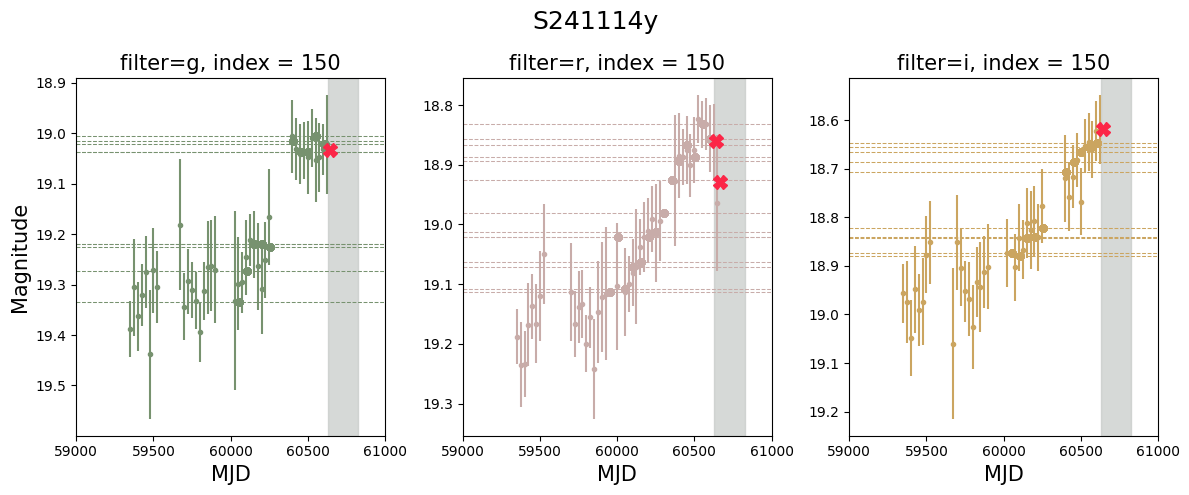

[None]

In [59]:
# plot given the values defined above
from bot.flares_utils import Plotter

# plot from an index:
plot_index = gri[0:1].tolist()
[Plotter(index_to_plot=[i], 
         color_to_plot='all', 
         agn=AGN, 
         rolling_stats=stats, 
         graceid='S241114y', 
         path_events_dictionary='bot/data').show_plots() for i in plot_index]

In [ ]:
# plot given only a graceid
graceid = 'S250319bu'

plot_index = gri[0:1].tolist()
[Plotter(index_to_plot=[i], 
         color_to_plot='all', 
         agn=AGN, 
         rolling_stats=stats, 
         graceid=graceid, 
         path_events_dictionary='bot/data').show_plots() for i in plot_index]

In [2]:
import gzip
import requests
import pickle
import pandas as pd
from io import StringIO
from astropy.time import Time
from datetime import datetime
import re

email = 'knolan@caltech.edu'
userpass = 'nxlk329'
auth_username = 'ztffps'
auth_password = 'dontgocrazy!'

In [4]:
def check_num_pending_zfps():
    """
    get number of pending ZFPS requests
    """
    action = 'Query Database'
    settings = {'email': email, 'userpass': userpass, 'option': 'Pending jobs', 'action': action}
    # load the full table of returned zfps:
    url = 'https://ztfweb.ipac.caltech.edu/cgi-bin/getBatchForcedPhotometryRequests.cgi'
    r = requests.get(url, auth = (auth_username, auth_password), params = settings)
    if r.status_code == 200:
        print("Script executed normally and queried the ZTF Batch Forced Photometry database.\n")
        html_content = StringIO(r.text)
        if "Zero records returned" in r.text:
            num_pending = 0
        else:
            full_table = pd.read_html(html_content)[0]
            num_pending= full_table.shape[0]
        print(f"Number of pending requests: {num_pending}")
        return num_pending
    else:
        print(f"Error: {r.status_code}")
        print(r.text)
        return None
    
num_pending = check_num_pending_zfps()

Script executed normally and queried the ZTF Batch Forced Photometry database.

Number of pending requests: 12426
